# C. Book Title Translation Application

*Note: This application involves PyTorch that may need to be downloaded. The instructions can be found here: https://pytorch.org/get-started/locally/. The application also requires CUDA and cuDNN (a CUDA library) be installed as well, you can install/update both using these commands:

`conda install -c anaconda cudatoolkit`

`conda install -c anaconda cudnn`

Installation tutorial if the code above doesn't work: https://medium.com/@afierror14/how-to-install-cuda-11-8-cudnn-9-1-pytorch-on-windows-anaconda-bf6af1a16aa6

<br>

Please follow the User Guide for more details.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from bs4 import BeautifulSoup
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
#from selenium.webdriver.common.by import By
import time

import requests
import re
import string
import math
import copy
import random
from typing import Tuple
   
import pymysql
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from deep_translator import GoogleTranslator
import MeCab
from fugashi import Tagger
import urllib.parse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import Tensor

import ipywidgets as widgets
from ipywidgets import Layout, Box, VBox, HBox

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#initialize cuDNN
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

# Invoke the ritual at the start of your program
force_cudnn_initialization()

In [6]:
torch.backends.cudnn.benchmark = True

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xemyc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Collect and Tidy Datasets for Language Translation

**Note: Due to the processing power and time it takes to produce 50,000 sentences in each language, each language will be converted to a `.csv` file which will be used for the rest of the program. The code required to scrape the data will be disabled so it should not affect the application when it runs.**

- Scrape the data from various sources to produce 50,000 identical sentences for each language: English, French, and Japanese.\*
- Clean the data using regex to stop any non-alphabetical character (with the exception of punctuation) in English and French, and any non-latin characters in Japanese.\**
- Create a dataframe and `.csv` for each language dataset. 
    - The `.csv`s are created due to the time it takes to for the data to be scraped. 
- Use each language `.csv` into a single one so the file can be cleaned and manipulated.
- Use the `.csv` file to run the rest of the model. The code can be ran if wanted, but it may take some time as scraping and translating 50,000 sentences of each language dataset.

<br>

*Japanese and English sentences come from https://tangorin.com/sentences?search=a. The French language data is created by using the English sentences and translating them into French to ensure the same sentences are used.
<br>
** Any numbers or English characters seen in the Japanese dataset are actually unicode and are not considered English characters. More information can be found here: https://www.localizingjapan.com/blog/2012/01/20/regular-expressions-for-japanese-text/ and http://www.rikai.com/library/kanjitables/kanji_codes.unicode.shtml

### 1. Scrape Data

#### Japanese + English

- The purpose of using Japanese first is to remove any numbers and English letters that may affect the result of the translation model.
- The English sentences will be scraped based on the Japanese sentences. The code will check to see if the Japanese sentences is identical to the ones in `japanese_sentences` and scrape the English translations of the sentences in `japanese_sentences`.

In [12]:
new_japanese_df = pd.read_csv('japanese_language_data.csv')

In [13]:
new_japanese_df.head()

,japanese
0,きみにちょっとしたものをもってきたよ。
1,すぐに戻ります。
2,何と言ったら良いか分かりません。
3,それは最近の写真？
4,すぐに諦めて昼寝をするかも知れない。


In [14]:
new_japanese_df.tail()

,japanese
49995,私は女性が男性より道徳的だという考えにはまったく同調しません。
49996,私は試験の前にもう一度テキストに目を通した。
49997,私は姉よりたくさんドレスを持っています。
49998,私は三ポンドしか持っていなかった。
49999,私は口語英語に一層興味があります。


In [15]:
new_english_df = pd.read_csv('english_language_data.csv')

In [16]:
new_english_df.head()

,english
0,I brought you a little something.
1,I'll return immediately.
2,I don't know what I should say.
3,Is that a recent photo?
4,I may give up soon and just take a nap.


In [17]:
new_english_df.tail()

,english
49995,I certainly don't subscribe to the view that w...
49996,I ran through the textbook once more before th...
49997,I have more dresses than my sister.
49998,I had no more than three pounds.
49999,I'm more interested in spoken English.


#### French
- The `GoogleTranslator` API from `deep_translator` will be used to create 50,000 French sentences from `english_sentences`.
- The translator API can only handle 5,000 sentences at a time, so the sentences will need to be split up by every 5,000 so it can run properly.

In [19]:
new_french_df = pd.read_csv('french_language_data.csv')

In [20]:
new_french_df.head()

,french
0,Je t'ai apporté un petit quelque chose.
1,Je reviens immédiatement.
2,Je ne sais pas quoi dire.
3,Est-ce une photo récente ?
4,Je vais peut-être bientôt abandonner et juste ...


In [21]:
new_french_df.tail()

,french
49995,Je ne souscris certainement pas à l’idée selon...
49996,J'ai parcouru le manuel une fois de plus avant...
49997,J'ai plus de robes que ma sœur.
49998,Je n’avais pas plus de trois livres.
49999,Je suis plus intéressé par l'anglais parlé.


### 2. Merge the Dataframes Together

In [23]:
language_data_df = pd.concat([new_english_df, new_french_df, new_japanese_df], axis=1)

In [24]:
language_data_df.head()

,english,french,japanese
0,I brought you a little something.,Je t'ai apporté un petit quelque chose.,きみにちょっとしたものをもってきたよ。
1,I'll return immediately.,Je reviens immédiatement.,すぐに戻ります。
2,I don't know what I should say.,Je ne sais pas quoi dire.,何と言ったら良いか分かりません。
3,Is that a recent photo?,Est-ce une photo récente ?,それは最近の写真？
4,I may give up soon and just take a nap.,Je vais peut-être bientôt abandonner et juste ...,すぐに諦めて昼寝をするかも知れない。


In [25]:
language_data_df.tail()

,english,french,japanese
49995,I certainly don't subscribe to the view that w...,Je ne souscris certainement pas à l’idée selon...,私は女性が男性より道徳的だという考えにはまったく同調しません。
49996,I ran through the textbook once more before th...,J'ai parcouru le manuel une fois de plus avant...,私は試験の前にもう一度テキストに目を通した。
49997,I have more dresses than my sister.,J'ai plus de robes que ma sœur.,私は姉よりたくさんドレスを持っています。
49998,I had no more than three pounds.,Je n’avais pas plus de trois livres.,私は三ポンドしか持っていなかった。
49999,I'm more interested in spoken English.,Je suis plus intéressé par l'anglais parlé.,私は口語英語に一層興味があります。


### 3. Convert DataFrame to `.csv`

By converting to a `.csv` file, it will allow the data to be reused and provides a permanent solution to pull data from.

### 4. Use the `language_data_training.csv` File

For the rest of this project, the `language_data_training.csv` file will be used.

In [28]:
new_language_data_df = pd.read_csv('language_data_training.csv')

In [29]:
new_language_data_df.head()

,english,french,japanese
0,I brought you a little something.,Je t'ai apporté un petit quelque chose.,きみにちょっとしたものをもってきたよ。
1,I'll return immediately.,Je reviens immédiatement.,すぐに戻ります。
2,I don't know what I should say.,Je ne sais pas quoi dire.,何と言ったら良いか分かりません。
3,Is that a recent photo?,Est-ce une photo récente ?,それは最近の写真？
4,I may give up soon and just take a nap.,Je vais peut-être bientôt abandonner et juste ...,すぐに諦めて昼寝をするかも知れない。


In [30]:
new_language_data_df.tail()

,english,french,japanese
49995,I certainly don't subscribe to the view that w...,Je ne souscris certainement pas à l’idée selon...,私は女性が男性より道徳的だという考えにはまったく同調しません。
49996,I ran through the textbook once more before th...,J'ai parcouru le manuel une fois de plus avant...,私は試験の前にもう一度テキストに目を通した。
49997,I have more dresses than my sister.,J'ai plus de robes que ma sœur.,私は姉よりたくさんドレスを持っています。
49998,I had no more than three pounds.,Je n’avais pas plus de trois livres.,私は三ポンドしか持っていなかった。
49999,I'm more interested in spoken English.,Je suis plus intéressé par l'anglais parlé.,私は口語英語に一層興味があります。


## Connect Database for Book Titles

- The `book_titles.sql` database contains the top 50 books in English, French, and Japanese. It contains the title, author(s), publishing date, and the original language the book was written in.* 
- The database involved data entry from various websites to get the top 50 books in each language, as well as additional information related to the book.

<br>
*Although the book(s) are written in another language, the translated versions will still be considered. There will be no duplicates within each language.

In [32]:
db_name = "book_titles"
db_host = "localhost"
db_username = "root"
db_password = "fMCX7dJHn@fDQ.M"

try:
    connection = pymysql.connect(host = db_host,
                           port = int(3306),
                           user = "root",
                           password = db_password,
                           db = db_name)
except e:
    print (e)
if connection:
    print ("connection successful")
else:
    print ("error")

connection successful


#### Main Tables

##### English Books

In [35]:
english_books_df = pd.read_sql_query("select * from english_books", connection)
english_books_df.head()

,id_en,title_en,author_id_en,publish_date_en,original_lang_id_en
0,1,To Kill a Mockingbird,1,1960-07-11,1
1,2,Harry Potter and the Sorcerer's Stone,2,1997-06-26,1
2,3,The Great Gatsby,3,1925-04-10,1
3,4,Animal Farm,4,1945-08-17,1
4,5,1984,4,1949-06-08,1


##### French Books

In [37]:
french_books_df = pd.read_sql_query("select * from french_books", connection)
french_books_df.head()

,id_fr,title_fr,author_id_fr,publish_date_fr,original_lang_id_fr
0,1,La dialectique de la raison,42,1983-11-03,5
1,2,Le grand Meaulnes,43,2006-09-20,3
2,3,L'Espèce humaine,44,1947-01-01,3
3,4,Alcools,45,1966-10-28,3
4,5,Aurélien,46,1944-01-01,3


##### Japanese Books

In [39]:
japanese_books_df = pd.read_sql_query("select * from japanese_books", connection)
japanese_books_df.head()

,id_jp,title_jp,author_id_jp,publish_date_jp,original_lang_id_jp
0,1,銀河英雄伝説 1 黎明篇,90,1982-11-01,15
1,2,竜馬がゆく 一,91,1963-01-01,15
2,3,図書館戦争シリーズ,92,2006-02-01,15
3,4,鬼平犯科帳,93,2000-01-01,15
4,5,坂の上の雲 一,91,1999-01-01,15


#### Supporting Tables

##### Authors

In [42]:
authors_df = pd.read_sql_query("select * from authors", connection)
authors_df.head()

,author_id,first_name,last_name,translated_name,nationality,birth,death,num_books_written
0,1,Harper,Lee,ハーパー・リー,United States,1926-04-28,2016-02-19,2
1,2,J.K.,Rowling,J・K・ローリング,United Kingdom,1965-07-31,None,18
2,3,F. Scott,Fitzgerald,F・スコット・フィッツジェラルド,United States,1896-09-24,1940-12-21,4
3,4,George,Orwell,ジョージ・オーウェル,United Kingdom,1903-06-25,1950-01-21,13
4,5,J.R.R.,Tolkien,J・R・R・トールキン,United Kingdom,1892-01-03,1973-09-02,17


##### Languages

In [44]:
languages_df = pd.read_sql_query("select * from languages", connection)
languages_df.head()

,lang_id,languages
0,1,English
1,2,Spanish
2,3,French
3,4,Portuguese
4,5,German


## Tokenize and Pad Datasets for Language Translation

- Split the `new_language_data_df` into three new dataframes based on the language.
- Remove all punctuation from all sentences before tokenizing.
    - The only exception is the hyphen in French sentences.
- Add start and end tokens to each sentence (in each language).
- Each sentence will be tokenized by each word in order to create an accurate language translation model.
    - Each word within each individual sentence will be tokenized because by tokenizing each sentence separately, the context for each sentence will be preserved.
    - Only English and French will work for `word_tokenize` in `NLTK`. Japanese will be using `MeCab` to tokenize.

### 1. Word Tokenization

In [47]:
new_english_df = new_language_data_df['english']
new_french_df = new_language_data_df['french']
new_japanese_df = new_language_data_df['japanese']

In [48]:
tokenized_en = []
tokenized_fr = []
tokenized_jp = []

In [49]:
for s_en in new_english_df.to_numpy().tolist():
    pattern = pattern = r"\b\w+['-]\w+\b|\b\w+\b|['-]"
    tokenized_words = re.findall(pattern, s_en)

    tokenized_en.append([word.lower() for word in tokenized_words])
    
    #new_s_en = re.sub(r'[^\w\s]', '', s_en)
    #new_s_en = new_s_en.lower()
    #tokenized_en.append(word_tokenize(new_s_en, language='english'))

In [50]:
for s_fr in new_french_df.to_numpy().tolist():
    s_fr.replace("’", "'")
    s_fr.replace("\u200b", "")
    #remove = fixed.replace("-", "") #doesn't remove hyphens
    #pattern = r"[{}]".format(remove)

    punc = "«»" #’
    tokenized_words = re.sub(r"[%s]+" %punc, "", s_fr)

    pattern = pattern = r"\b\w+['-]\w+\b|\b\w+\b|['-]"
    new_tokenized_words = re.findall(pattern, tokenized_words)
    tokenized_fr.append([word.lower() for word in new_tokenized_words])
    
    #remove = string.punctuation
    #remove = remove.replace("-", "") #doesn't remove hyphens
    #pattern = r"[{}]".format(remove)
    
    #punc = "«»’"
    #s_fr = re.sub(r"[%s]+" %punc, "", s_fr)
    
    #new_s_fr = re.sub(pattern, "", s_fr)
    #new_s_fr = new_s_fr.replace("\u200b", "")
    #new_s_fr = new_s_fr.lower()
    #tokenized_fr.append(word_tokenize(new_s_fr, language='french'))

In [51]:
mecab = MeCab.Tagger("-Owakati")
for s in new_japanese_df.to_numpy().tolist():
    punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
    new_s = re.sub(r"[%s]+" %punc, "", s)
    tokenized = list(mecab.parse(new_s).split(" "))
    #print(tokenized)
    tokenized = tokenized[:-1]
    tokenized_jp.append(tokenized)

### 2. Add Special Tokens: `<bos>`, `<eos>`, `<pad>`, and `<unk>`

- `<bos>` stands for "Beginning of Sentence".
- `<eos>` stands for "End of Sentence".

In [53]:
def add_tokens(tokenized_array):
    for s in tokenized_array:
        s.insert(0, '<bos>')
        s.append('<eos>')
        
add_tokens(tokenized_en)
add_tokens(tokenized_fr)
add_tokens(tokenized_jp)

#### `<pad>`

- The `PAD_TOKEN` or `<pad>` adds extra "padding" for each sentence within `tokenized_en`, `tokenized_fr`, and `tokenized_jp` in order for all sentences to have the same length within each language.

In [55]:
padded_en = []
padded_fr = []
padded_jp = []

In [56]:
PAD_TOKEN = '<pad>'

def add_pad(tokenized_sent, padded_sent):
    max_length = 0
    
    for sent in tokenized_sent:
        if max_length < len(sent):
            max_length = len(sent)

    for sent in tokenized_sent:
        if len(sent) < max_length:
            padded_sent.append(sent + [PAD_TOKEN] * (max_length - len(sent)))
        else:
            padded_sent.append(sent)

add_pad(tokenized_en, padded_en)
add_pad(tokenized_fr, padded_fr)
add_pad(tokenized_jp, padded_jp)

### 3. Map Tokens to Unique IDs

- Each word (or token) will have it's own unique identifier (or indices).
- The special tokens `<bos>`, `<eos>`, `<pad>`, and `<unk>` will have the first 4 identifiers (starting from 0) for English, French, and Japanese.
- Get the total size of words in English, French, and Japanese.

#### `<unk>`

- `<unk>` is used for words that aren't available in the dictionary. It's index will be listed as the `len(japanese_vocab)` since the Japanese dictionary has the most words, and `<unk>` shouldn't overlap any words that are already there.
- This will be used once the translation model has been created and the model can start translating sentences.

In [59]:
special_tokens = ['<bos>', '<eos>', '<pad>', '<unk>']

In [60]:
english_vocab = {token: idx for idx, token in enumerate(special_tokens)}
french_vocab = {token: idx for idx, token in enumerate(special_tokens)}
japanese_vocab = {token: idx for idx, token in enumerate(special_tokens)}

In [61]:
def update_vocab(vocab, list_of_sentences):
    #this will start the indexing after <unk>
    current_index = len(vocab) #starts at 4 due to the special tokens
    for s in list_of_sentences:
        #print(s)
        for token in s:
            #print(token)
            #checks to see if the token has already been added to vocab or not
            if token not in vocab:
                vocab[token] = current_index
                current_index = current_index + 1

In [62]:
update_vocab(english_vocab, padded_en)
update_vocab(french_vocab, padded_fr)
update_vocab(japanese_vocab, padded_jp)

In [63]:
english_vocab_size = len(english_vocab)
french_vocab_size = len(french_vocab)
japanese_vocab_size = len(japanese_vocab)

### 4. Convert Mapped Tokens to Their Unique IDs

- Based off the `english_vocab`, `french_vocab`, and `japanese_vocab`'s unique IDs (for each token), format the arrays similar to the `tokenized_en`, `tokenized_fr`, and `tokenized_jp`.
    - Rather than having the array look like this: `[['i', 'brought', 'you', 'a', 'little', 'something']...`.
    - It will look like this: `[[4293, 3365, 738, 4284, 3101, 3262, 4317, 2826]...`.

In [65]:
indices_en = []
indices_fr = []
indices_jp = []

In [66]:
def convert_to_id(indices, padded_sent, vocab):
    for sent in padded_sent:
        ids = []
        for token in sent:
            ids.append(vocab[token])
        indices.append(ids)

convert_to_id(indices_en, padded_en, english_vocab)
convert_to_id(indices_fr, padded_fr, french_vocab)
convert_to_id(indices_jp, padded_jp, japanese_vocab)

### 5. Convert Tokenized Tokens to Tensors

- The tensors between English, French, and Japanese all need to have the same shape.
    - English has the minimum shape, so French and Japanese need to be resized to match the same size as English.

In [68]:
tensor_tokenized_en = torch.tensor(indices_en).to(device)
tensor_tokenized_fr = torch.tensor(indices_fr).to(device)
tensor_tokenized_jp = torch.tensor(indices_jp).to(device)

In [69]:
min_length = min(tensor_tokenized_en.shape[1], tensor_tokenized_fr.shape[1], tensor_tokenized_jp.shape[1])
#print(min_length)
tensor_tokenized_en = tensor_tokenized_en[:, :min_length]
tensor_tokenized_fr = tensor_tokenized_fr[:, :min_length]
tensor_tokenized_jp = tensor_tokenized_jp[:, :min_length]

### 6. Create Datasets

##### English to French

In [72]:
enfr_dataset = TensorDataset(tensor_tokenized_en, tensor_tokenized_fr)

##### English to Japanese

In [74]:
enjp_dataset = TensorDataset(tensor_tokenized_en, tensor_tokenized_jp)

##### French to Japanese

In [76]:
frjp_dataset = TensorDataset(tensor_tokenized_fr, tensor_tokenized_jp)

##### French to English

In [78]:
fren_dataset = TensorDataset(tensor_tokenized_fr, tensor_tokenized_en)

##### Japanese to English

In [80]:
jpen_dataset = TensorDataset(tensor_tokenized_jp, tensor_tokenized_en)

##### Japanese to French

In [82]:
jpfr_dataset = TensorDataset(tensor_tokenized_jp, tensor_tokenized_fr)

### 7. Split Datasets into Training and Testing Sets

- The batch size of 32 will be used.
    - Number of batches = 150,000 (Total Sentences) / 32 (Batch Size) ≈ 4687 batches for the English, French, and Japanese vocabulary.

In [84]:
def split_datasets(dataset):
    total_size = len(dataset)
    test_size = int(0.2 * total_size)
    train_valid_size = total_size - test_size #this will be 0.8 of the dataset

    train_valid_dataset, test_dataset = random_split(dataset, [train_valid_size, test_size])

    return train_valid_dataset, test_dataset

In [85]:
def create_dataloaders(dataset, train_index, valid_index):
    batch_size = 32

    train_subset = Subset(dataset, train_index)
    valid_subset = Subset(dataset, valid_index)

    train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle=True)
    valid_loader = DataLoader(valid_subset, batch_size = batch_size, shuffle = False)

    return train_loader, valid_loader

##### English to French

In [87]:
train_valid_enfr_dataset, test_enfr_dataset = split_datasets(enfr_dataset)
#train_enfr_dataset, valid_enfr_dataset, test_enfr_dataset = split_datasets(enfr_dataset)

##### English to Japanese

In [89]:
train_valid_enjp_dataset, test_enjp_dataset = split_datasets(enjp_dataset)
#train_enjp_dataset, valid_enjp_dataset, test_enjp_dataset = split_datasets(enjp_dataset)

##### French to Japanese

In [91]:
train_valid_frjp_dataset, test_frjp_dataset = split_datasets(frjp_dataset)
#train_frjp_dataset, valid_frjp_dataset, test_frjp_dataset = split_datasets(frjp_dataset)

##### French to English

In [93]:
train_valid_fren_dataset, test_fren_dataset = split_datasets(fren_dataset)
#train_fren_dataset, valid_fren_dataset, test_fren_dataset = split_datasets(fren_dataset)

##### Japanese to English

In [95]:
train_valid_jpen_dataset, test_jpen_dataset = split_datasets(jpen_dataset)
#train_jpen_dataset, valid_jpen_dataset, test_jpen_dataset = split_datasets(jpen_dataset)

##### Japanese to French

In [97]:
train_valid_jpfr_dataset, test_jpfr_dataset = split_datasets(jpfr_dataset)
#train_jpfr_dataset, valid_jpfr_dataset, test_jpfr_dataset = split_datasets(jpfr_dataset)

## Create the Language Translation Model ([Language Translation with TorchText Guide](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html))

In order for the model to have a higher chance of accurate translation, the tokenized data will need to be split up into multiple language-pairs: English (Encoder) to French (Decoder), English to Japanese, French to Japanese, as well as vice versa.

- Each language pair will contain its own model as if they get mixed up, they won't work properly.

### 1. Encoder + Attention + Decoder

- Since the dataset is relatively small and only uses 2,000 sentences per language, `embedding_dim` should range between 50 to 100, and `hidden_dim` should range from 100 to 200 to start.
    - `embedding_dim` refers to the size of the embedding vector for each token. A higher `embedding_dim` means the model can potentially caputre more nuanced meanings of each token. 
    - `encoder_units` and `decoder_units` aka `hidden_dim` referes to the size of the hidden state in the Long Short-Term Memory (type of recurrent neural network) layers. A larger `hidden_dim` allows the model to remember more information about the sequence.

#### Encoder

- The Encoder processes the input sequence (language that is being translated) and creates hidden states, which captures important information about the input.

In [101]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size: int, embedding_dim: int, encoder_hidden_dim: int, decoder_hidden_dim: int, dropout: float):
        super().__init__()
        self.input_vocab_size = input_vocab_size
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.dropout = dropout

        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional = True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input: Tensor) -> Tuple[Tensor]:
        embedded = self.dropout(self.embedding(input))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden

#### Attention Layer

- The Attention Layer acts like a spotlight and helps the decoder focus on specific words from the input. It assigns weights to the input words based on their relevance to the current decoding step.
    - The Context Vector is the sum of a calculated weight of the input hidden states from the Attention Layer. The Decoder cmbines the Context Vector with its own hidden state to help make better predictions for the next output word.

In [103]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_dim: int, decoder_hidden_dim: int, attention_dim: int):
        super().__init__()
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.attn_in = (encoder_hidden_dim * 2) + decoder_hidden_dim
        self.attention = nn.Linear(self.attn_in, attention_dim)

    def forward(self, decoder_hidden: Tensor, encoder_outputs: Tensor) -> Tensor:
        input_length = encoder_outputs.shape[0]
        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, input_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attention(torch.cat((repeated_decoder_hidden, encoder_outputs), dim = 2)))
        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)

#### Decoder
- The Decoder starts with a blank slate (initial hidden state) and needs to know which parts of the input are relevant for the current word.

In [105]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size: int, embedding_dim: int, encoder_hidden_dim: int, decoder_hidden_dim: int, dropout: int, attention: nn.Module):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        self.target_vocab_size = target_vocab_size
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(target_vocab_size, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.out = nn.Linear(self.attention.attn_in + embedding_dim, target_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self, decoder_hidden: Tensor, encoder_outputs: Tensor) -> Tensor:
        a = self.attention(decoder_hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted_encoder_rep = torch.bmm(a, encoder_outputs)
        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep


    def forward(self, input: Tensor, decoder_hidden: Tensor, encoder_outputs: Tensor) -> Tuple[Tensor]:
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden, encoder_outputs)
        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)
        output = self.out(torch.cat((output, weighted_encoder_rep, embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)

### 2. Seq2Seq Model

- This model uses the Encoder, Attention Layer, and Decoder to transform one sequence (the language being translated) into another sequence (the language it is being translated to).

In [107]:
#output_dim is input_vocab_size 
embedding_dim = 256  # Embedding dimension
encoder_hidden_dim = decoder_hidden_dim = 512 #encoder & decoder hidden dimension
dropout = 0.5  # Dropout rate
attention_dim = 256  # Attention dimension

In [108]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module, device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input: Tensor, target: Tensor, teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = input.shape[1]
        max_len = target.shape[0]
        target_vocab_size = self.decoder.target_vocab_size

        outputs = torch.zeros(max_len, batch_size, target_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(input)

        # first input to the decoder is the <eos> token
        output = target[0,:]

        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (target[t] if teacher_force else top1)

        return outputs

##### English to French

In [110]:
attention_enfr_one = BahdanauAttention(encoder_hidden_dim, decoder_hidden_dim, attention_dim)

encoder_en_one = Encoder(english_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout)
decoder_fr_one = Decoder(french_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention_enfr_one)

In [111]:
enfr_model = Seq2Seq(encoder_en_one, decoder_fr_one, device).to(device)

##### English to Japanese

In [113]:
attention_enjp_two = BahdanauAttention(encoder_hidden_dim, decoder_hidden_dim, attention_dim)

encoder_en_two = Encoder(english_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout)
decoder_jp_two = Decoder(japanese_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention_enjp_two)

In [114]:
enjp_model = Seq2Seq(encoder_en_two, decoder_jp_two, device).to(device)

##### French to Japanese

In [116]:
attention_frjp_three = BahdanauAttention(encoder_hidden_dim, decoder_hidden_dim, attention_dim)

encoder_fr_three = Encoder(french_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout)
decoder_jp_three = Decoder(japanese_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention_frjp_three)

In [117]:
frjp_model = Seq2Seq(encoder_fr_three, decoder_jp_three, device).to(device)

##### French to English

In [119]:
attention_fren_four = BahdanauAttention(encoder_hidden_dim, decoder_hidden_dim, attention_dim)

encoder_fr_four = Encoder(french_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout)
decoder_en_four = Decoder(english_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention_fren_four)

In [120]:
fren_model = Seq2Seq(encoder_fr_four, decoder_en_four, device).to(device)

##### Japanese to English

In [122]:
attention_jpen_five = BahdanauAttention(encoder_hidden_dim, decoder_hidden_dim, attention_dim)

encoder_jp_five = Encoder(japanese_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout)
decoder_en_five = Decoder(english_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention_jpen_five)

In [123]:
jpen_model = Seq2Seq(encoder_jp_five, decoder_en_five, device).to(device)

##### Japanese to French

In [125]:
attention_jpfr_six = BahdanauAttention(encoder_hidden_dim, decoder_hidden_dim, attention_dim)

encoder_jp_six = Encoder(japanese_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout)
decoder_fr_six = Decoder(french_vocab_size, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout, attention_jpfr_six)

In [126]:
jpfr_model = Seq2Seq(encoder_jp_six, decoder_fr_six, device).to(device)

### 2. Initialize Model Weight

In [128]:
def init_weights(model: nn.Module):
    for name, parameters in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(parameters.data, mean=0, std=0.01)
        else:
            nn.init.constant_(parameters.data, 0)

In [129]:
def count_parameters(model: nn.Module):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

##### English to French

In [131]:
enfr_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14849, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (attention): Linear(in_features=1536, out_features=256, bias=True)
    )
    (embedding): Embedding(20424, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=20424, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [132]:
print(f'The enfr_model has {count_parameters(enfr_model):,} trainable parameters')

The enfr_model has 51,689,416 trainable parameters


##### English to Japanese

In [134]:
enjp_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(14849, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (attention): Linear(in_features=1536, out_features=256, bias=True)
    )
    (embedding): Embedding(20824, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=20824, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [135]:
print(f'The enjp_model has {count_parameters(enjp_model):,} trainable parameters')

The enjp_model has 52,509,016 trainable parameters


##### French to Japanese

In [137]:
frjp_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20424, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (attention): Linear(in_features=1536, out_features=256, bias=True)
    )
    (embedding): Embedding(20824, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=20824, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [138]:
print(f'The frjp_model has {count_parameters(frjp_model):,} trainable parameters')

The frjp_model has 53,936,216 trainable parameters


##### French to English

In [140]:
fren_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20424, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (attention): Linear(in_features=1536, out_features=256, bias=True)
    )
    (embedding): Embedding(14849, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=14849, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [141]:
print(f'The fren_model has {count_parameters(fren_model):,} trainable parameters')

The fren_model has 41,693,441 trainable parameters


##### Japanese to English

In [143]:
jpen_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20824, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (attention): Linear(in_features=1536, out_features=256, bias=True)
    )
    (embedding): Embedding(14849, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=14849, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [144]:
print(f'The jpen_model has {count_parameters(jpen_model):,} trainable parameters')

The jpen_model has 41,795,841 trainable parameters


##### Japanese to French

In [146]:
jpfr_model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20824, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (attention): Linear(in_features=1536, out_features=256, bias=True)
    )
    (embedding): Embedding(20424, 256)
    (rnn): GRU(1280, 512)
    (out): Linear(in_features=1792, out_features=20424, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [147]:
print(f'The jpfr_model has {count_parameters(jpfr_model):,} trainable parameters')

The jpfr_model has 53,219,016 trainable parameters


### 3. Define Optimizer + Loss Function

- Due to the small size of sentences within each language (English, French, and Japanese), the combined loss for each language pair may have a higher loss value than a dataset that contains more data.

In [149]:
en_pad_idx = english_vocab[PAD_TOKEN]
fr_pad_idx = french_vocab[PAD_TOKEN]
jp_pad_idx = japanese_vocab[PAD_TOKEN]

In [150]:
#L2 Regularization
learning_rate = 0.001
weight_decay = 1e-5

##### English to French

In [152]:
enfr_optimizer = optim.Adam(enfr_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [153]:
#this will ignore the <'pad'> token from the input/source
enfr_criterion = nn.CrossEntropyLoss(ignore_index=en_pad_idx)

##### English to Japanese

In [155]:
enjp_optimizer = optim.Adam(enjp_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [156]:
enjp_criterion = nn.CrossEntropyLoss(ignore_index=en_pad_idx)

##### French to Japanese

In [158]:
frjp_optimizer = optim.Adam(frjp_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [159]:
frjp_criterion = nn.CrossEntropyLoss(ignore_index=fr_pad_idx)

##### French to English

In [161]:
fren_optimizer = optim.Adam(fren_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [162]:
fren_criterion = nn.CrossEntropyLoss(ignore_index=fr_pad_idx)

##### Japanese to English

In [164]:
jpen_optimizer = optim.Adam(jpen_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [165]:
jpen_criterion = nn.CrossEntropyLoss(ignore_index=jp_pad_idx)

##### Japanese to French

In [167]:
jpfr_optimizer = optim.Adam(jpfr_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [168]:
jpfr_criterion = nn.CrossEntropyLoss(ignore_index=jp_pad_idx)

## Train the Language Translation Model ([Language Translation with TorchText Guide](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html))

- Due to the differences of Japanese from English and French, the `epochs` will be increased to 20 for all models that include Japanese. For any other English or French models, the `epochs = 10`.

In [170]:
epochs = 20
clip = 1.0
k = 5
teacher_forcing_ratio = 0.5

In [171]:
def epoch_time(start_time: int, end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 1. Create the Training Loop

In [173]:
def train_step(model: nn.Module, iterator: torch.utils.data.DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, clip: float):
    model.train()
    epoch_loss = 0

    for _, (input, target) in enumerate(iterator):
        input, target = input.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(input, target).to(device)
        output = output[1:].view(-1, output.shape[-1])
        target = target[1:].view(-1)

        loss = criterion(output, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 2. Create the Evaluation Loop

In [175]:
def evaluate(model: nn.Module, iterator: torch.utils.data.DataLoader, criterion: nn.Module):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():

        for _, (input, target) in enumerate(iterator):
            input, target = input.to(device), target.to(device)

            output = model(input, target, 0).to(device) #turn off teacher forcing
            output = output[1:].view(-1, output.shape[-1])
            target = target[1:].view(-1)

            loss = criterion(output, target)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### 3. Model Training

In [177]:
def model_training(model, train_loader, valid_loader, test_dataset, optimizer, criterion, epochs, clip, train_loss_dict, valid_loss_dict, fold):
    best_valid_loss = float('inf')
    patience = 5
    patience_counter = 0

    train_loss_dict[fold + 1] = {}
    valid_loss_dict[fold + 1] = {}
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
    
    for e in range(epochs):
    
        start_time = time.time()
    
        train_loss = train_step(model, train_loader, optimizer, criterion, clip)
        valid_loss = evaluate(model, valid_loader, criterion)
    
        end_time = time.time()
    
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {e + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    
        #perplexity is useful in comparing models (lower is better) and in tracking improvements during training over time.
        print(f'\tTrain Loss: {train_loss:.3f} | Train Perplexity: {math.exp(train_loss):7.3f}')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid Perplexity: {math.exp(valid_loss):7.3f}')
        train_loss_dict[fold + 1][e] = train_loss
        valid_loss_dict[fold + 1][e] = valid_loss
        
        scheduler.step(valid_loss)

        #early stopping will prevent the data from continuing if the data is starting to overfit
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    #create DataLoader for the test set
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    test_loss = evaluate(model, test_loader, criterion)
    print("------------------------------------------------------------")
    print(f'Test Loss: {test_loss:.3f} | Test Perplexity: {math.exp(test_loss):7.3f} | Total Time: {end_time - start_time}')
    
   # test_loss = evaluate(model, test_loader, criterion)
    #print("------------------------------------------------------------")
    #print(f'Test Loss: {test_loss:.3f} | Test Perplexity: {math.exp(test_loss):7.3f} | Total Time: {end_time - start_time}')

### 4. K-Fold Cross Validation

- This helps prevent the data from overfitting*.
- After the model has been trained, the model will be saved, so there will be no need to re-run the `k_fold` function again as it will take too much time.


*Information regarding overfitting and underfitting of data can be found here: https://www.baeldung.com/cs/training-validation-loss-deep-learning

In [179]:
def k_fold(model, train_valid_dataset, test_dataset, optimizer, criterion, k, epochs, clip, model_train_loss_dict, model_valid_loss_dict):
    kfold = KFold(n_splits = k, shuffle = True, random_state = 42)
    fold_results = []

    for fold, (train_index, valid_index) in enumerate(kfold.split(train_valid_dataset)):
        print(f'Fold {fold + 1}/{k}')

        train_loader, valid_loader = create_dataloaders(train_valid_dataset, train_index, valid_index)
        model_training(model, train_loader, valid_loader, test_dataset, optimizer, criterion, epochs, clip, model_train_loss_dict, model_valid_loss_dict, fold)

        valid_loss = evaluate(model, valid_loader, criterion)
        fold_results.append(valid_loss)

    print(f'K-Fold Cross Validation Results: {fold_results}')
    print(f'Average Validation Loss: {np.mean(fold_results):.3f}')

##### English to French

- To see the results of the `k_fold` function, the results can be found in the `kfold_enfr_results.txt` file.

In [181]:
#the trained model is now saved, so the code above (to train the model) is no longer needed
new_enfr_model = torch.load("enfr_model.pt")

##### English to Japanese

- See `kfold_enjp_results.txt` to see the results of `k_fold`.

In [183]:
new_enjp_model = torch.load("enjp_model.pt")

##### French to Japanese

- See `kfold_frjp_results.txt` to see the results of `k_fold`.

In [185]:
new_frjp_model = torch.load("frjp_model.pt")

##### French to English

- See `kfold_fren_results.txt` to see the results of `k_fold`.

In [187]:
new_fren_model = torch.load("fren_model.pt")

##### Japanese to English

- See `kfold_jpen_results.txt` to see the results of `k_fold`.

In [189]:
new_jpen_model = torch.load("jpen_model.pt")

##### Japanese to French

- See `kfold_jpfr_results.txt` to see the results of `k_fold`.

In [191]:
new_jpfr_model = torch.load("jpfr_model.pt")

## Evaluating the Translation

### 1. Create Functions to Analyze Input Sentences

- The input sentences will need to go through the same cleaning and tokenization process as the sentences in `tokenized_en`, `tokenzied_fr`, and `tokenized_jp` used to train the model.

In [194]:
#removes all punctuation so it looks like the tokens in tokenized_en
def analyze_english(sentence):
    #tokenized_words = re.sub(r"[^\w\s'-]", '', sentence)

    pattern = r"\b\w+['-]\w+\b|\b\w+\b|['-]"
    tokenized_words = re.findall(pattern, sentence)
    new_token_words = [word.lower() for word in tokenized_words]
    
    #new_token_words = tokenized_words.lower()
    #new_token_words = nltk.word_tokenize(new_token_words)
    return new_token_words

In [195]:
#removes all punctuation so it looks like the tokens in tokenized_fr
def analyze_french(sentence):
    #fixed = string.punctuation
    sentence.replace("’", "'")
    sentence.replace("\u200b", "")
    #remove = fixed.replace("-", "") #doesn't remove hyphens
    #pattern = r"[{}]".format(remove)

    punc = "«»" #’
    tokenized_words = re.sub(r"[%s]+" %punc, "", sentence)

    pattern = r"\b\w+['-]\w+\b|\b\w+\b|['-]"
    new_tokenized_words = re.findall(pattern, tokenized_words)
    new_token_words = [word.lower() for word in new_tokenized_words]
    #new_token_words = re.sub(pattern, "", tokenized_words)
    #new_token_words = new_token_words.replace("\u200b", "")
    #new_token_words = new_token_words.lower()
    #new_token_words = word_tokenize(new_token_words, language='french')

    return new_token_words

In [196]:
#removes all punctuation so it looks like the tokens in tokenized_jp
def analyze_japanese(sentence):
    punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
    tokenized_words = re.sub(r"[%s]+" %punc, "", sentence)
    new_token_words = list(mecab.parse(tokenized_words).split(" "))
    new_token_words = new_token_words[:-1]
    
    return new_token_words

### 2. Create Functions To Convert to Indices and Tokens

In [198]:
#this reverses the location of the index and token from token: index (regular) to index: token (reversed)
def reverse_vocab(vocab):
    return {index: token for token, index in vocab.items()}

In [199]:
def convert_to_id(tokenized_sentence, vocab):
    ids = []
    for token in tokenized_sentence:
        #use the normal vocab dictionary to get the index
        #if the word is not found, len(vocab) - 1 (depending on the vocab list)

        if vocab == english_vocab:
        #add if statements for each vocabulary
            token_id = vocab.get(token, len(english_vocab) - 1)
            ids.append(token_id)
        elif vocab == french_vocab:
            token_id = vocab.get(token, len(french_vocab) - 1)
            ids.append(token_id)
        elif vocab == japanese_vocab:
            token_id = vocab.get(token, len(japanese_vocab) - 1)
            ids.append(token_id)
    return ids

In [200]:
def convert_to_tokens(indices, reverse_vocab):
    tokens = []
    for idx in indices:
        # Use the reverse_vocab function to get the token
        # If the index is not found, '<unk>' is the placeholder
        token = reverse_vocab.get(idx, '<unk>')
        tokens.append(token)
    return tokens

### 3. Translate Input Sentence to Target Sentence

In [202]:
def translate_sentence(sentence, source_tokenizer, target_tokenizer, source_vocab, target_vocab, model, device, max_output_length = 50):
    model.eval()

    with torch.no_grad():
        #tokenize the input sentence
        if source_tokenizer == tokenized_en:
            tokenized_words = analyze_english(sentence)
        elif source_tokenizer == tokenized_fr: 
            tokenized_words = analyze_french(sentence)
        elif source_tokenizer == tokenized_jp:
            tokenized_words = analyze_japanese(sentence)
        
        #add <bos> and <eos> tokens to the input sentence
        tokenized_words.insert(0, '<bos>')
        tokenized_words.append('<eos>')
        #print(tokenized_words)
        
        #convert tokens to indices
        indices_words = convert_to_id(tokenized_words, source_vocab)
        #print(indices_words)
        
        #convert to Tensor
        tokenized_tensor = torch.LongTensor(indices_words).unsqueeze(-1).to(device)
        #print(tokenized_tensor)
        #print(tokenized_tensor.shape)
    
        #encode the source sentence
        encoder_outputs, hidden = model.encoder(tokenized_tensor)
        #print(encoder_outputs, hidden)
        #print(hidden)

        #initialize the input to the decoder
        inputs = torch.LongTensor([target_vocab['<bos>']]).to(device)
        #print(inputs)

        translated_tokens = []
        for i in range(max_output_length):
            output, hidden = model.decoder(inputs, hidden, encoder_outputs)
            predicted_token_id = output.argmax(1).item()
            #hidden = hidden.detach()
            #print(f"Step {i}, Predicted Token ID: {predicted_token_id}")  # Debug print


            # Assuming 'output' is the raw output from the decoder
            softmax_scores = F.softmax(output, dim=1)
            top_scores, top_indices = softmax_scores.topk(5)  # Adjust the number as needed
            #print("Top 5 scores:", top_scores)
            #print("Top 5 indices:", top_indices)


            translated_tokens.append(predicted_token_id)

            #output_probabilities = torch.softmax(output, dim=1)
            #print(output_probabilities)

            #print(output)
            #break if <eos> is generated
            if predicted_token_id == target_vocab['<eos>']:
                break

            #prepare next token
            inputs = torch.LongTensor([predicted_token_id]).to(device)

        #convert ids to tokens
        translated_tokens = translated_tokens[:-1] #drops the <eos> token in the sentence
        translated_words = convert_to_tokens(translated_tokens, reverse_vocab(target_vocab))
    return translated_words
            

### 4. Translation Accuracy - BLEU Score
- BLEU score will be rated from 0 to 1, with 0 having the lowest quality translation, and 1 being the best.
| BLEU Score | Interpretation |
|-:|:-|
| 0 - 0.09 | Worst quality |
| 0.1 - 0.19 | Poor quality |
| 0.2 - 0.29 | Average quality |
| 0.3 - 0.39 | Good quality |
| 0.4 - 0.49 | Better quality |
| 0.5 - 0.59 | High quality |
| > 0.6 | Very high quality |

<br>

*Note: To reference how difficult it is to achieve a BLEU score of 1, very few human translations have ever reached the perfect score.

- The native translations are pulled from Tatoeba (https://tatoeba.org/en), a large, open source collection of sentences and translations.
- There will be one basic sentence, one more complex sentence, and a book title (that is not in the list) to see how well the model is able to translate.

In [205]:
reference_en_basic = analyze_english("You are in my way.")
reference_fr_basic = analyze_french("Vous êtes sur mon chemin.")
reference_jp_basic = analyze_japanese("あなたは私の邪魔をしています。")

In [206]:
reference_en_complex = analyze_english("We must learn to live together as brothers, or we will perish together as fools.")
reference_fr_complex = analyze_french("Nous devons apprendre à vivre ensemble comme des frères, ou nous périrons ensemble comme des idiots.")
reference_jp_complex = analyze_japanese("私たちは兄弟として共に生きることを知らなければならない。さもなくば、愚か者として共に滅びるであろう。")

In [207]:
reference_en_book = analyze_english("Lord of the Flies")
reference_fr_book = analyze_french("Sa Majeste Des Mouches")
reference_jp_book = analyze_japanese("蠅の王")

In [208]:
def bleu_score(reference, prediction):
    print("Reference: " + str(reference))
    print("Prediction: " + str(prediction))

    score = sentence_bleu([reference], prediction, weights = (0.5, 0.5))

    if score < 0.01:
        score = 0

    print("BLEU Score: " + str(round(score, 2)))
    return round(score, 2)

#### French to English

##### Basic Sentence

In [211]:
predictions_fren_basic = translate_sentence("Vous êtes sur mon chemin.", tokenized_fr, tokenized_en, french_vocab, english_vocab, new_fren_model, device)

In [212]:
fren_bleu_score_basic = bleu_score(reference_en_basic, predictions_fren_basic)

Reference: ['you', 'are', 'in', 'my', 'way']
Prediction: ['you', 'are', 'on', 'my', 'way']
BLEU Score: 0.63


##### Complex Sentence

In [214]:
predictions_fren_complex = translate_sentence("Nous devons apprendre à vivre ensemble comme des frères, ou nous périrons ensemble comme des idiots.", tokenized_fr, tokenized_en, french_vocab, english_vocab, new_fren_model, device)

In [215]:
fren_bleu_score_complex = bleu_score(reference_en_complex, predictions_fren_complex)

Reference: ['we', 'must', 'learn', 'to', 'live', 'together', 'as', 'brothers', 'or', 'we', 'will', 'perish', 'together', 'as', 'fools']
Prediction: ['we', 'we', 'learn', 'to', 'live', 'together', 'as', 'of', 'brothers', 'or', 'we', 'the', 'together', 'as', 'of', 'you']
BLEU Score: 0.57


##### Book Title

In [217]:
predictions_fren_book = translate_sentence("Sa Majeste Des Mouches", tokenized_fr, tokenized_en, french_vocab, english_vocab, new_fren_model, device)

In [218]:
fren_bleu_score_book = bleu_score(reference_en_book, predictions_fren_book)

Reference: ['lord', 'of', 'the', 'flies']
Prediction: ['his']
BLEU Score: 0


#### Japanese to English

##### Basic Sentence

In [221]:
predictions_jpen_basic = translate_sentence("あなたは私の邪魔をしています。", tokenized_jp, tokenized_en, japanese_vocab, english_vocab, new_jpen_model, device)

In [222]:
jpen_bleu_score_basic = bleu_score(reference_en_basic, predictions_jpen_basic)

Reference: ['you', 'are', 'in', 'my', 'way']
Prediction: ['you']
BLEU Score: 0


##### Complex Sentence

In [224]:
predictions_jpen_complex = translate_sentence("私たちは兄弟として共に生きることを知らなければならない。さもなくば、愚か者として共に滅びるであろう。", tokenized_jp, tokenized_en, japanese_vocab, english_vocab, new_jpen_model, device)

In [225]:
jpen_bleu_score_complex = bleu_score(reference_en_complex, predictions_jpen_complex)

Reference: ['we', 'must', 'learn', 'to', 'live', 'together', 'as', 'brothers', 'or', 'we', 'will', 'perish', 'together', 'as', 'fools']
Prediction: ['i', 'to']
BLEU Score: 0


##### Book Title

In [227]:
predictions_jpen_book = translate_sentence("蠅の王", tokenized_jp, tokenized_en, japanese_vocab, english_vocab, new_jpen_model, device)

In [228]:
jpen_bleu_score_book = bleu_score(reference_en_book, predictions_jpen_book)

Reference: ['lord', 'of', 'the', 'flies']
Prediction: ['to', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the', 'the']
BLEU Score: 0


#### English to French

##### Basic Sentence

In [231]:
predictions_enfr_basic = translate_sentence("You are in my way.", tokenized_en, tokenized_fr, english_vocab, french_vocab, new_enfr_model, device)

In [232]:
enfr_bleu_score_basic = bleu_score(reference_fr_basic, predictions_enfr_basic)

Reference: ['vous', 'êtes', 'sur', 'mon', 'chemin']
Prediction: ['vous', 'sont', 'dans', 'mon', 'chemin']
BLEU Score: 0.39


##### Complex Sentence

In [234]:
predictions_enfr_complex = translate_sentence("We must learn to live together as brothers, or we will perish together as fools.", tokenized_en, tokenized_fr, english_vocab, french_vocab, new_enfr_model, device)

In [235]:
enfr_bleu_score_complex = bleu_score(reference_fr_complex, predictions_enfr_complex)

Reference: ['nous', 'devons', 'apprendre', 'à', 'vivre', 'ensemble', 'comme', 'des', 'frères', 'ou', 'nous', 'périrons', 'ensemble', 'comme', 'des', 'idiots']
Prediction: ['nous', 'doit', 'apprendre', 'à', 'vivre']
BLEU Score: 0.07


##### Book Title

In [237]:
predictions_enfr_book = translate_sentence("Lord of the Flies", tokenized_en, tokenized_fr, english_vocab, french_vocab, new_enfr_model, device)

In [238]:
enfr_bleu_score_book = bleu_score(reference_fr_book, predictions_enfr_book)

Reference: ['sa', 'majeste', 'des', 'mouches']
Prediction: []
BLEU Score: 0


#### Japanese to French

##### Basic Sentence

In [241]:
predictions_jpfr_basic = translate_sentence("あなたは私の邪魔をしています。", tokenized_jp, tokenized_fr, japanese_vocab, french_vocab, new_jpfr_model, device)

In [242]:
jpfr_bleu_score_basic = bleu_score(reference_fr_basic, predictions_jpfr_basic)

Reference: ['vous', 'êtes', 'sur', 'mon', 'chemin']
Prediction: []
BLEU Score: 0


##### Complex Sentence

In [244]:
predictions_jpfr_complex = translate_sentence("私たちは兄弟として共に生きることを知らなければならない。さもなくば、愚か者として共に滅びるであろう。", tokenized_jp, tokenized_fr, japanese_vocab, french_vocab, new_jpfr_model, device)

In [245]:
jpfr_bleu_score_complex = bleu_score(reference_fr_complex, predictions_jpfr_complex)

Reference: ['nous', 'devons', 'apprendre', 'à', 'vivre', 'ensemble', 'comme', 'des', 'frères', 'ou', 'nous', 'périrons', 'ensemble', 'comme', 'des', 'idiots']
Prediction: ['de', 'de', 'de', 'de', 'de']
BLEU Score: 0


##### Book Title

In [247]:
predictions_jpfr_book = translate_sentence("蠅の王", tokenized_jp, tokenized_fr, japanese_vocab, french_vocab, new_jpfr_model, device)

In [248]:
jpfr_bleu_score_book = bleu_score(reference_fr_book, predictions_jpfr_book)

Reference: ['sa', 'majeste', 'des', 'mouches']
Prediction: ['de', 'de']
BLEU Score: 0


#### English to Japanese

##### Basic Sentence

In [251]:
predictions_enjp_basic = translate_sentence("You are in my way.", tokenized_en, tokenized_jp, english_vocab, japanese_vocab, new_enjp_model, device)

In [252]:
enjp_bleu_score_basic = bleu_score(reference_jp_basic, predictions_enjp_basic)

Reference: ['あなた', 'は', '私', 'の', '邪魔', 'を', 'し', 'て', 'い', 'ます']
Prediction: ['に', 'の', 'の', 'の', 'の']
BLEU Score: 0


##### Complex Sentence

In [254]:
predictions_enjp_complex = translate_sentence("We must learn to live together as brothers, or we will perish together as fools.", tokenized_en, tokenized_jp, english_vocab, japanese_vocab, new_enjp_model, device)

In [255]:
enjp_bleu_score_complex = bleu_score(reference_jp_complex, predictions_enjp_complex)

Reference: ['私', 'たち', 'は', '兄弟', 'と', 'し', 'て', '共', 'に', '生きる', 'こと', 'を', '知ら', 'なけれ', 'ば', 'なら', 'ない', 'さ', 'も', 'なく', 'ば', '愚か者', 'と', 'し', 'て', '共', 'に', '滅びる', 'で', 'あろう']
Prediction: ['私', 'は', 'の', 'に', 'に', 'に', 'に', 'に', 'の', '私', 'は', 'に', 'に', 'に', 'に']
BLEU Score: 0


##### Book Title

In [257]:
predictions_enjp_book = translate_sentence("Lord of the Flies", tokenized_en, tokenized_jp, english_vocab, japanese_vocab, new_enjp_model, device)

In [258]:
enjp_bleu_score_book = bleu_score(reference_jp_book, predictions_enjp_book)

Reference: ['蠅', 'の', '王']
Prediction: ['の', 'の', 'の', 'に']
BLEU Score: 0


#### French to Japanese

##### Basic Sentence

In [261]:
predictions_frjp_basic = translate_sentence("Vous êtes sur mon chemin.", tokenized_fr, tokenized_jp, french_vocab, japanese_vocab, new_frjp_model, device)

In [262]:
frjp_bleu_score_basic = bleu_score(reference_jp_basic, predictions_frjp_basic)

Reference: ['あなた', 'は', '私', 'の', '邪魔', 'を', 'し', 'て', 'い', 'ます']
Prediction: ['て', 'に', 'を', 'を', 'に']
BLEU Score: 0


##### Complex Sentence

In [264]:
predictions_frjp_complex = translate_sentence("Nous devons apprendre à vivre ensemble comme des frères, ou nous périrons ensemble comme des idiots.", tokenized_fr, tokenized_jp, french_vocab, japanese_vocab, new_frjp_model, device)

In [265]:
frjp_bleu_score_complex = bleu_score(reference_jp_complex, predictions_frjp_complex)

Reference: ['私', 'たち', 'は', '兄弟', 'と', 'し', 'て', '共', 'に', '生きる', 'こと', 'を', '知ら', 'なけれ', 'ば', 'なら', 'ない', 'さ', 'も', 'なく', 'ば', '愚か者', 'と', 'し', 'て', '共', 'に', '滅びる', 'で', 'あろう']
Prediction: ['に', 'に', 'を', 'に', 'は', 'に', 'の', 'の', 'に', 'か', 'に', 'を', 'に', 'の', 'の', 'を']
BLEU Score: 0


##### Book Title

In [267]:
predictions_frjp_book = translate_sentence("Sa Majeste Des Mouches", tokenized_fr, tokenized_jp, french_vocab, japanese_vocab, new_frjp_model, device)

In [268]:
frjp_bleu_score_book = bleu_score(reference_jp_book, predictions_frjp_book)

Reference: ['蠅', 'の', '王']
Prediction: ['彼', 'に', 'の', 'に']
BLEU Score: 0


## Interface

- The interface is based on the idea that the store employees will be using it to determine what books they can sell at their different locations.

### 1. Get the Titles of the Various Books

In [271]:
english_books = pd.read_csv('english_books.csv')

In [272]:
english_books.head()

,id_en,title_en,author_id_en,publish_date_en,original_lang_id_en
0,1,To Kill a Mockingbird,1,1960-07-11,1
1,2,Harry Potter and the Sorcerer's Stone,2,1997-06-26,1
2,3,The Great Gatsby,3,1925-04-10,1
3,4,Animal Farm,4,1945-08-17,1
4,5,1984,4,1949-06-08,1


In [273]:
english_book_titles = english_books['title_en'].tolist()

In [274]:
french_books = pd.read_csv('french_books.csv')

In [275]:
french_books.head()

,id_fr,title_fr,author_id_fr,publish_date_fr,original_lang_id_fr
0,1,La dialectique de la raison,42,1983-11-03,5
1,2,Le grand Meaulnes,43,2006-09-20,3
2,3,L'Espèce humaine,44,1947-01-01,3
3,4,Alcools,45,1966-10-28,3
4,5,Aurélien,46,1944-01-01,3


In [276]:
french_book_titles = french_books['title_fr'].tolist()

In [277]:
japanese_books = pd.read_csv('japanese_books.csv')

In [278]:
japanese_books.head()

,id_jp,title_jp,author_id_jp,publish_date_jp,original_lang_id_jp
0,1,銀河英雄伝説 1 黎明篇,90,1982-11-01,15
1,2,竜馬がゆく 一,91,1963-01-01,15
2,3,図書館戦争シリーズ,92,2006-02-01,15
3,4,鬼平犯科帳,93,2000-01-01,15
4,5,坂の上の雲 一,91,1999-01-01,15


In [279]:
japanese_book_titles = japanese_books['title_jp'].tolist()

### 2. Create the Interface

In [281]:
#english titles
dropdown_en = widgets.Select(
    options= english_book_titles,
    description='Book Titles:',
    layout = Layout(width = '98%')
)

#french titles
dropdown_fr = widgets.Select(
    options= french_book_titles,
    description='Book Titles:',
    layout = Layout(width = '98%')
)

#japanese titles
dropdown_jp = widgets.Select(
    options= japanese_book_titles,
    description='Book Titles:',
    layout = Layout(width = '98%')
)



output = widgets.Output()

def translate_en_books(change):
    with output:
        output.clear_output()
        print(f"French Translation: {translate_sentence(change.new, tokenized_en, tokenized_fr, english_vocab, french_vocab, new_enfr_model, device)}")
        print(f"Japanese Translation: {translate_sentence(change.new, tokenized_en, tokenized_jp, english_vocab, japanese_vocab, new_enjp_model, device)}")

def translate_fr_books(change):
    with output:
        output.clear_output()
        print(f"English Translation: {translate_sentence(change.new, tokenized_fr, tokenized_en, french_vocab, english_vocab, new_fren_model, device)}")
        print(f"Japanese Translation: {translate_sentence(change.new, tokenized_fr, tokenized_jp, french_vocab, japanese_vocab, new_frjp_model, device)}")

def translate_jp_books(change):
    with output:
        output.clear_output()
        print(f"English Translation: {translate_sentence(change.new, tokenized_jp, tokenized_en, japanese_vocab, english_vocab, new_jpen_model, device)}")
        print(f"French Translation: {translate_sentence(change.new, tokenized_jp, tokenized_fr, japanese_vocab, french_vocab, new_jpfr_model, device)}")


dropdown_en.observe(translate_en_books, 'value')
left_box_en = widgets.VBox([dropdown_en])
right_box_en = widgets.VBox([output])

dropdown_fr.observe(translate_fr_books, 'value')
left_box_fr = widgets.VBox([dropdown_fr])
right_box_fr = widgets.VBox([output])

dropdown_jp.observe(translate_jp_books, 'value')
left_box_jp = widgets.VBox([dropdown_jp])
right_box_jp = widgets.VBox([output])


#create the tab contents
tab_contents = ['English Books', 'French Books', 'Japanese Books']
children = [HBox([left_box_en, right_box_en]), HBox([left_box_fr, right_box_fr]), HBox([left_box_jp, right_box_jp])]

#create the tab
tab = widgets.Tab()
tab.children = children
tab.titles = tab_contents

#display the tabs
display(tab)

## Data Visualizations

### 1. Line Plot of Train Loss and Valid Loss from Various Models

##### English to French

In [285]:
with open('enfr_train_loss.json') as json_file:
    enfr_train_loss = json.load(json_file)

In [286]:
with open('enfr_valid_loss.json') as json_file:
    enfr_valid_loss = json.load(json_file)

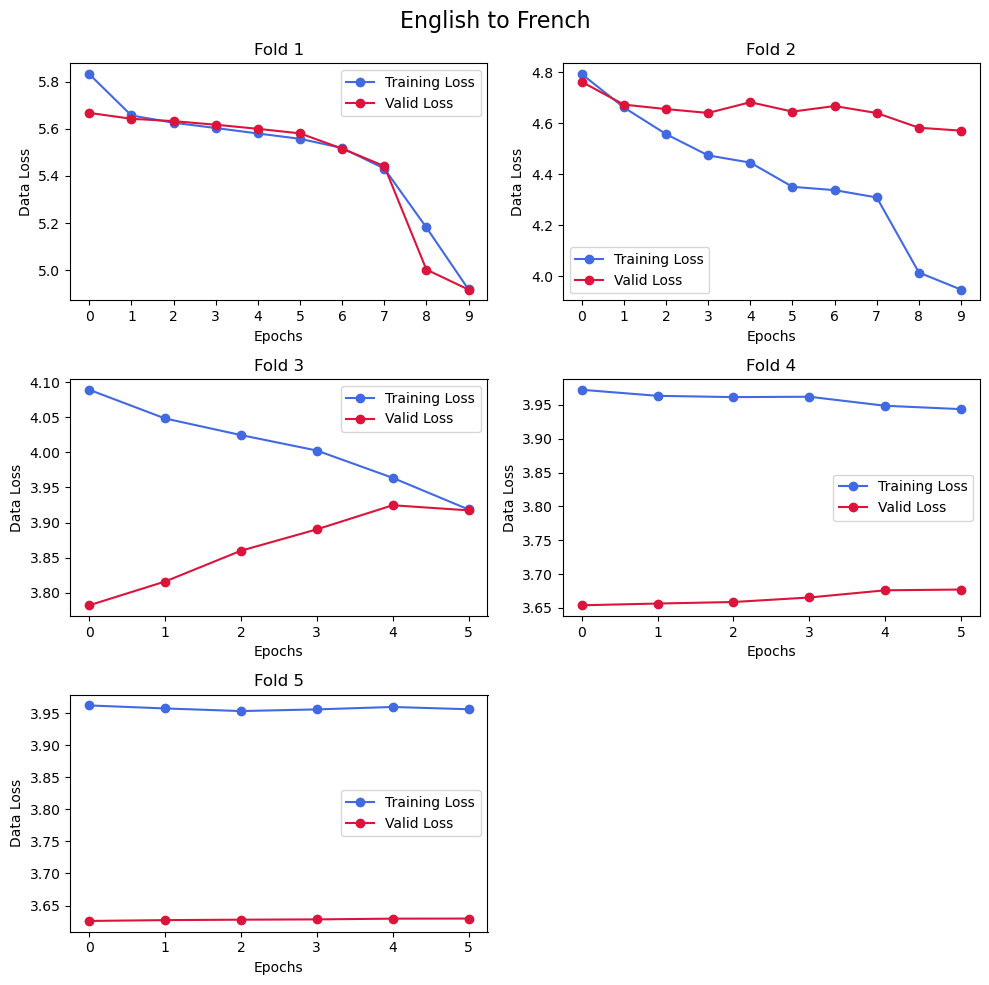

In [287]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs = axs.flatten()

#since the folds are identical in the train and valid loss
for i, key in enumerate(enfr_train_loss.keys()):
    x1 = list(enfr_train_loss[key].keys())
    y1 = list(enfr_train_loss[key].values())
    x2 = list(enfr_valid_loss[key].keys())
    y2 = list(enfr_valid_loss[key].values())

    axs[i].plot(x1, y1, marker = 'o', label="Training Loss", color = "royalblue")
    axs[i].plot(x2, y2, marker = 'o', label="Valid Loss", color="crimson")
    axs[i].set_title("Fold " + str(key))
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Data Loss")
    axs[i].set_xticks(np.arange(0, len(x1)))
    axs[i].legend()

#only creates graphs based on the amount of folds
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("English to French", fontsize = 16)
plt.tight_layout()
plt.show()

##### English to Japanese

In [289]:
with open('enjp_train_loss.json') as json_file:
    enjp_train_loss = json.load(json_file)

In [290]:
with open('enjp_valid_loss.json') as json_file:
    enjp_valid_loss = json.load(json_file)

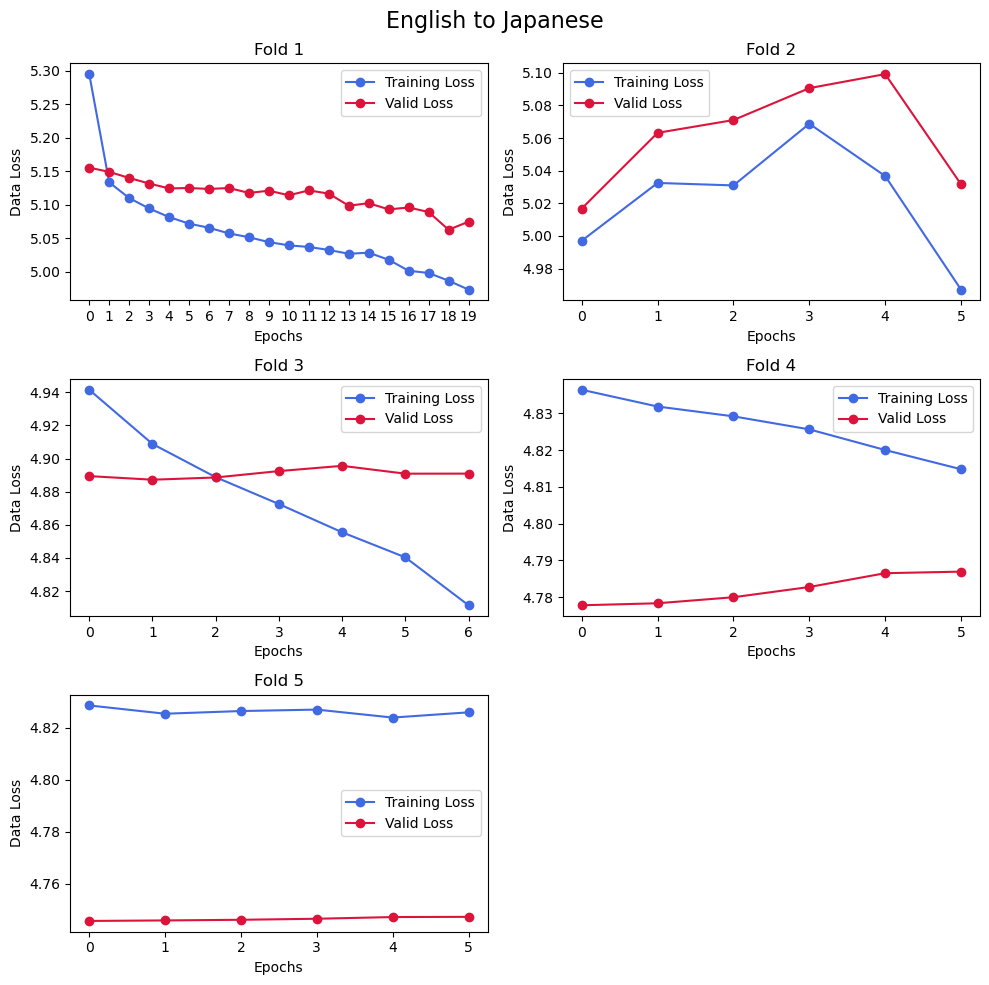

In [291]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs = axs.flatten()

#since the folds are identical in the train and valid loss
for i, key in enumerate(enjp_train_loss.keys()):
    x1 = list(enjp_train_loss[key].keys())
    y1 = list(enjp_train_loss[key].values())
    x2 = list(enjp_valid_loss[key].keys())
    y2 = list(enjp_valid_loss[key].values())

    axs[i].plot(x1, y1, marker = 'o', label="Training Loss", color = "royalblue")
    axs[i].plot(x2, y2, marker = 'o', label="Valid Loss", color="crimson")
    axs[i].set_title("Fold " + str(key))
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Data Loss")
    axs[i].set_xticks(np.arange(0, len(x1)))
    axs[i].legend()

#only creates graphs based on the amount of folds
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("English to Japanese", fontsize = 16)
plt.tight_layout()
plt.show()

##### French to Japanese

In [293]:
with open('frjp_train_loss.json') as json_file:
    frjp_train_loss = json.load(json_file)

In [294]:
with open('frjp_valid_loss.json') as json_file:
    frjp_valid_loss = json.load(json_file)

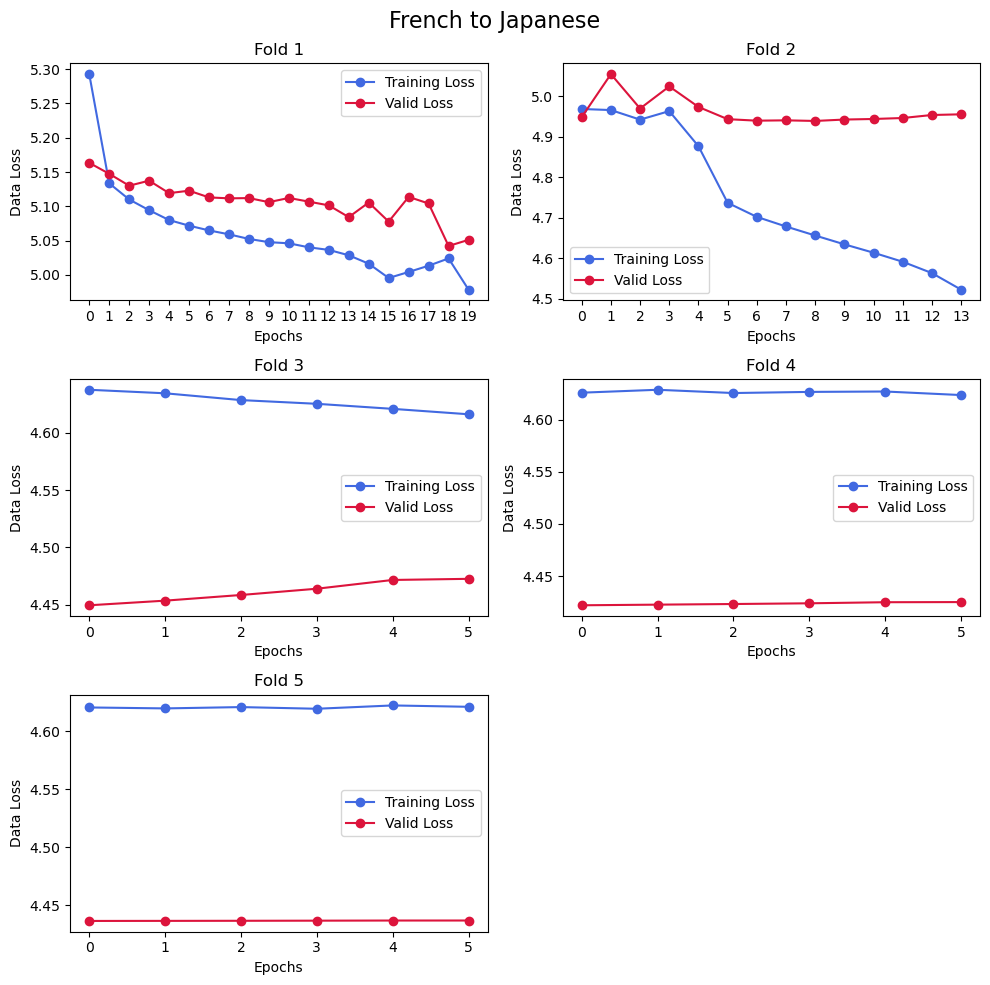

In [295]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs = axs.flatten()

#since the folds are identical in the train and valid loss
for i, key in enumerate(frjp_train_loss.keys()):
    x1 = list(frjp_train_loss[key].keys())
    y1 = list(frjp_train_loss[key].values())
    x2 = list(frjp_valid_loss[key].keys())
    y2 = list(frjp_valid_loss[key].values())

    axs[i].plot(x1, y1, marker = 'o', label="Training Loss", color = "royalblue")
    axs[i].plot(x2, y2, marker = 'o', label="Valid Loss", color="crimson")
    axs[i].set_title("Fold " + str(key))
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Data Loss")
    axs[i].set_xticks(np.arange(0, len(x1)))
    axs[i].legend()

#only creates graphs based on the amount of folds
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("French to Japanese", fontsize = 16)
plt.tight_layout()
plt.show()

##### French to English

In [297]:
with open('fren_train_loss.json') as json_file:
    fren_train_loss = json.load(json_file)

In [298]:
with open('fren_valid_loss.json') as json_file:
    fren_valid_loss = json.load(json_file)

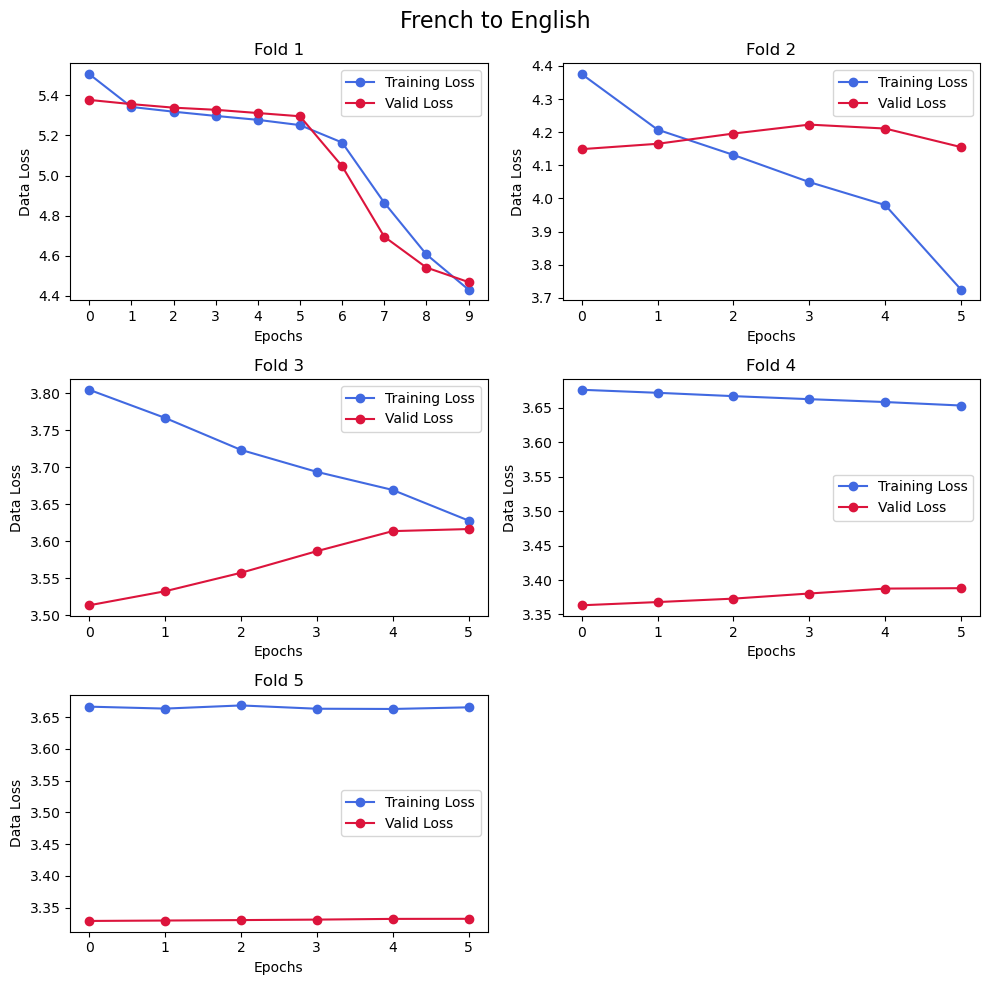

In [299]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs = axs.flatten()

#since the folds are identical in the train and valid loss
for i, key in enumerate(fren_train_loss.keys()):
    x1 = list(fren_train_loss[key].keys())
    y1 = list(fren_train_loss[key].values())
    x2 = list(fren_valid_loss[key].keys())
    y2 = list(fren_valid_loss[key].values())

    axs[i].plot(x1, y1, marker = 'o', label="Training Loss", color = "royalblue")
    axs[i].plot(x2, y2, marker = 'o', label="Valid Loss", color="crimson")
    axs[i].set_title("Fold " + str(key))
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Data Loss")
    axs[i].set_xticks(np.arange(0, len(x1)))
    axs[i].legend()

#only creates graphs based on the amount of folds
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("French to English", fontsize = 16)
plt.tight_layout()
plt.show()

##### Japanese to English

In [301]:
with open('jpen_train_loss.json') as json_file:
    jpen_train_loss = json.load(json_file)

In [302]:
with open('jpen_valid_loss.json') as json_file:
    jpen_valid_loss = json.load(json_file)

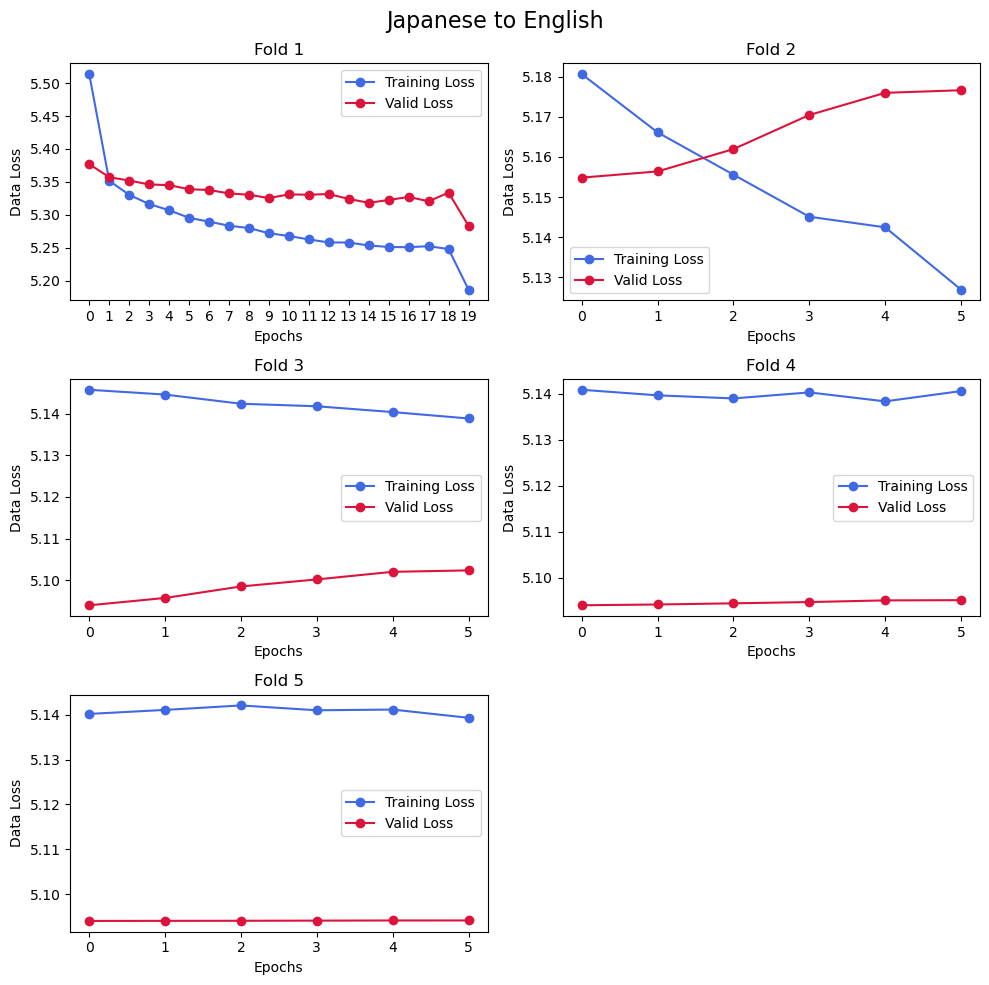

In [303]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs = axs.flatten()

#since the folds are identical in the train and valid loss
for i, key in enumerate(jpen_train_loss.keys()):
    x1 = list(jpen_train_loss[key].keys())
    y1 = list(jpen_train_loss[key].values())
    x2 = list(jpen_valid_loss[key].keys())
    y2 = list(jpen_valid_loss[key].values())

    axs[i].plot(x1, y1, marker = 'o', label="Training Loss", color = "royalblue")
    axs[i].plot(x2, y2, marker = 'o', label="Valid Loss", color="crimson")
    axs[i].set_title("Fold " + str(key))
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Data Loss")
    axs[i].set_xticks(np.arange(0, len(x1)))
    axs[i].legend()

#only creates graphs based on the amount of folds
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Japanese to English", fontsize = 16)
plt.tight_layout()
plt.show()

##### Japanese to French

In [305]:
with open('jpfr_train_loss.json') as json_file:
    jpfr_train_loss = json.load(json_file)

In [306]:
with open('jpfr_valid_loss.json') as json_file:
    jpfr_valid_loss = json.load(json_file)

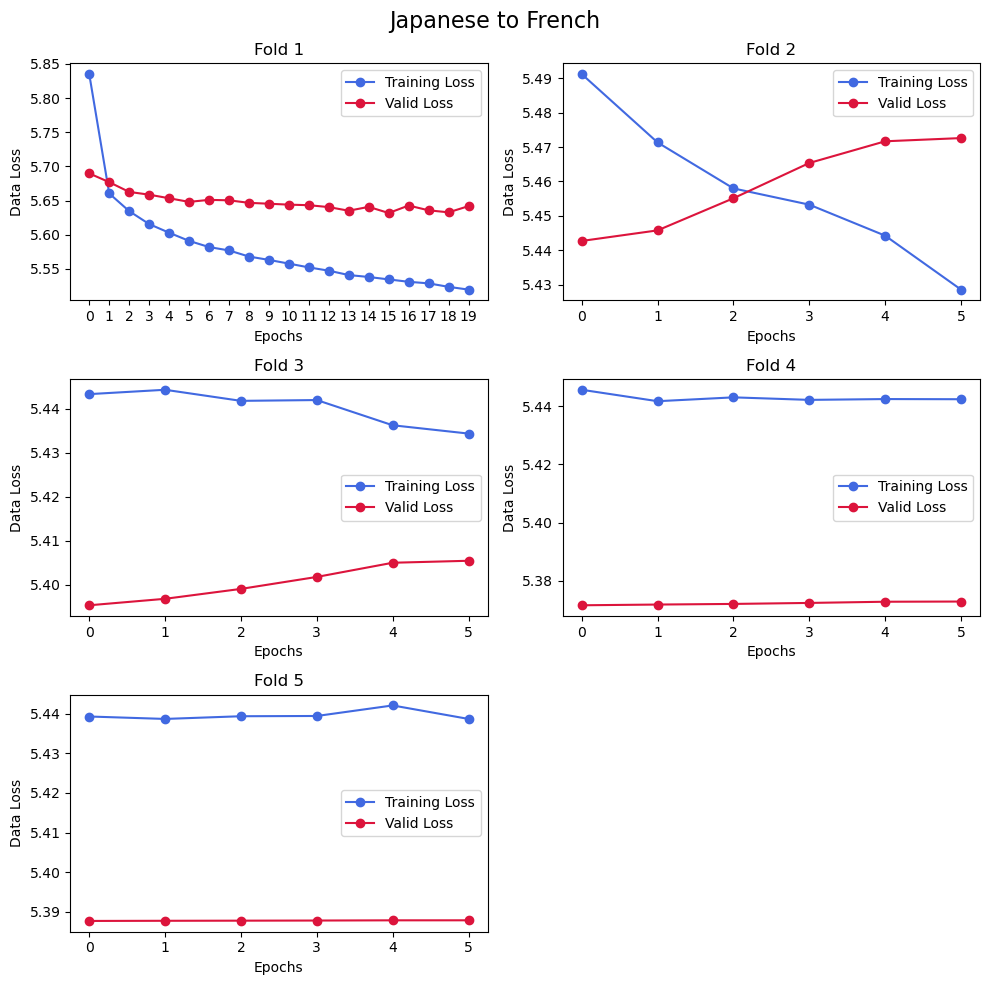

In [307]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs = axs.flatten()

#since the folds are identical in the train and valid loss
for i, key in enumerate(jpfr_train_loss.keys()):
    x1 = list(jpfr_train_loss[key].keys())
    y1 = list(jpfr_train_loss[key].values())
    x2 = list(jpfr_valid_loss[key].keys())
    y2 = list(jpfr_valid_loss[key].values())

    axs[i].plot(x1, y1, marker = 'o', label="Training Loss", color = "royalblue")
    axs[i].plot(x2, y2, marker = 'o', label="Valid Loss", color="crimson")
    axs[i].set_title("Fold " + str(key))
    axs[i].set_xlabel("Epochs")
    axs[i].set_ylabel("Data Loss")
    axs[i].set_xticks(np.arange(0, len(x1)))
    axs[i].legend()

#only creates graphs based on the amount of folds
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.suptitle("Japanese to French", fontsize = 16)
plt.tight_layout()
plt.show()

### 2. Heatmap of Machine Learning Language Translations Compared to Native Translations for Basic Sentences

In [309]:
def heatmap(reference, prediction, vocab, source, target):
    max_len = max(len(reference), len(prediction))
    reference += ["<PAD>"] * (max_len - len(reference))
    prediction += ["<PAD>"] * (max_len - len(prediction))

    unique_words = list(set(reference + prediction))

    reference_indices = convert_to_id(reference, vocab)
    prediction_indices = convert_to_id(prediction, vocab)
    
    conf_matrix = confusion_matrix(reference_indices, prediction_indices)


    #plot the heatmap
    sns.set(font="SimSun") #Seaborn is unable to read Japanese characters, so this font is the only one that will show Japanese characters
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=unique_words, yticklabels=unique_words)
    plt.xlabel('Predicted: ' + str(prediction))
    plt.ylabel('Reference: ' + str(reference))
    plt.title(source + " to " + target)
    plt.show()

##### French to English

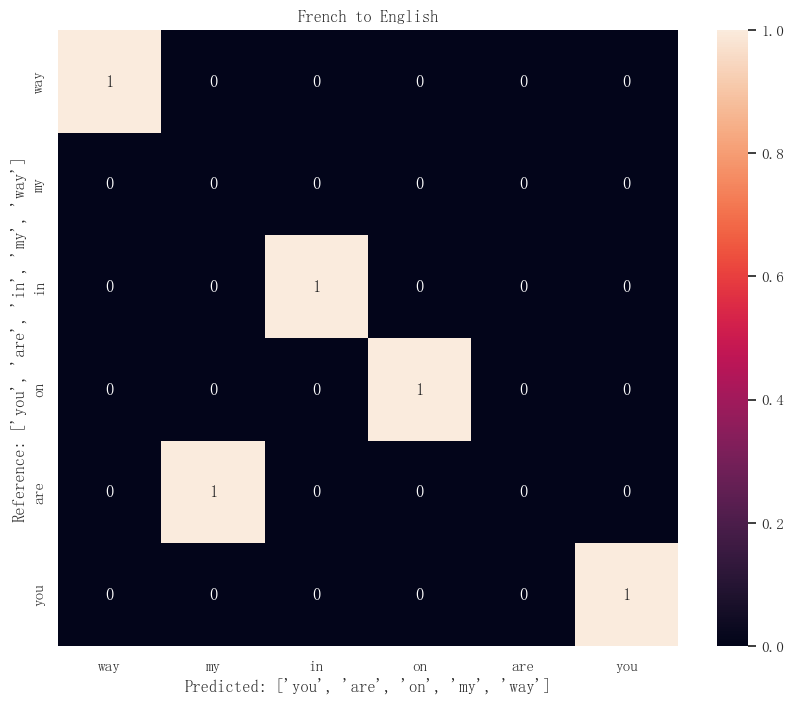

In [311]:
heatmap(reference_en_basic, predictions_fren_basic, english_vocab, "French", "English")

##### Japanese to English

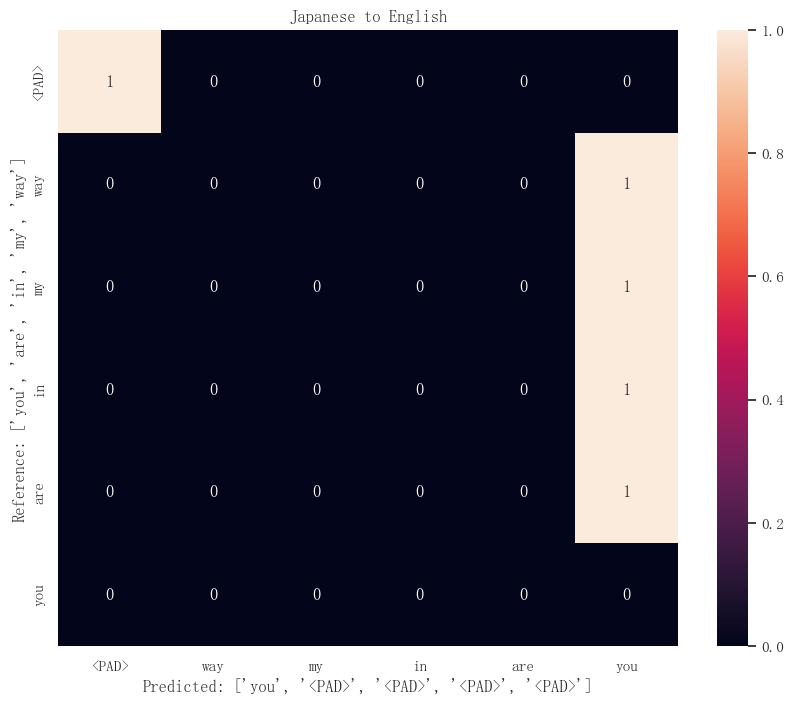

In [313]:
heatmap(reference_en_basic, predictions_jpen_basic, english_vocab, "Japanese", "English")

##### English to French

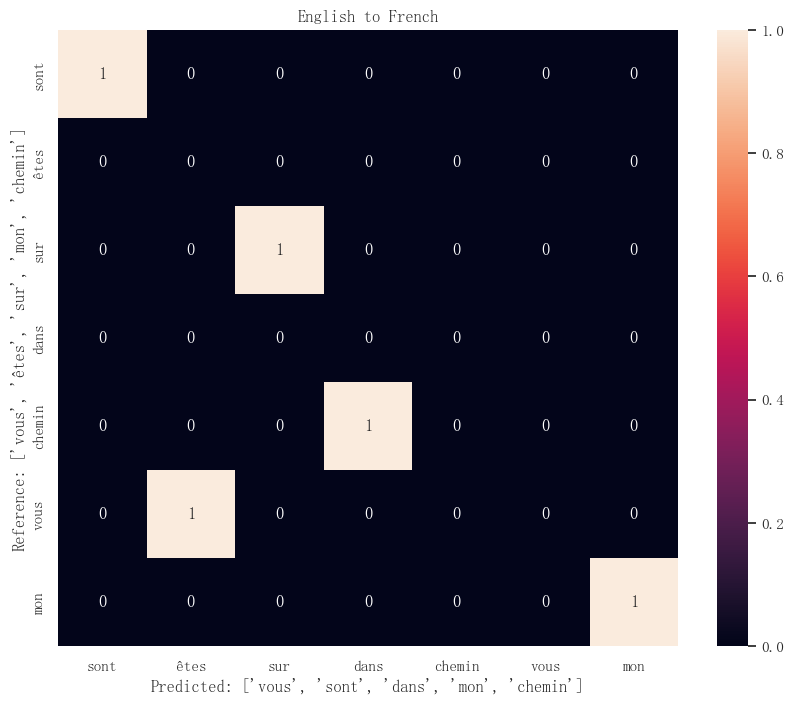

In [315]:
heatmap(reference_fr_basic, predictions_enfr_basic, french_vocab, "English", "French")

##### Japanese to French

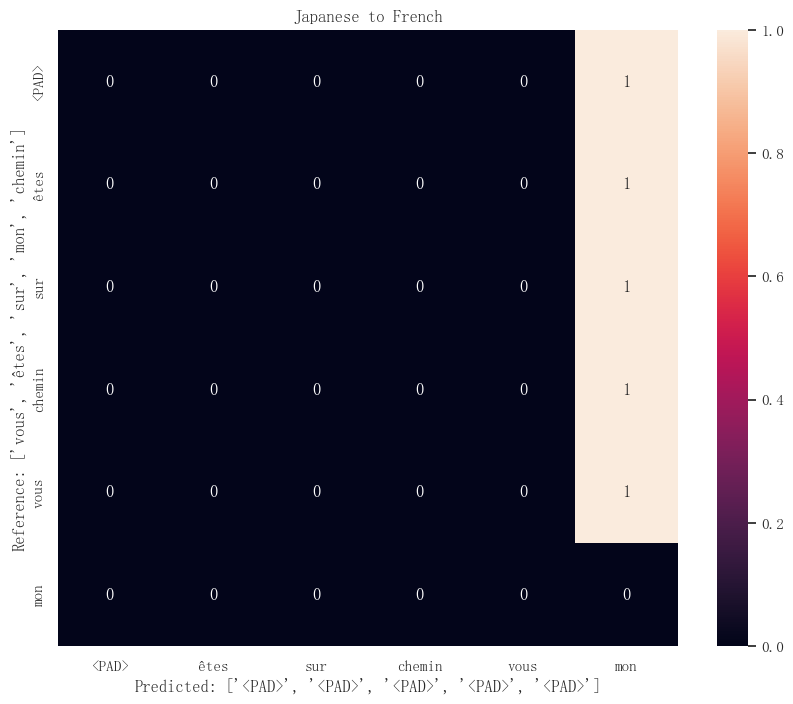

In [317]:
heatmap(reference_fr_basic, predictions_jpfr_basic, french_vocab, "Japanese", "French")

##### English to Japanese

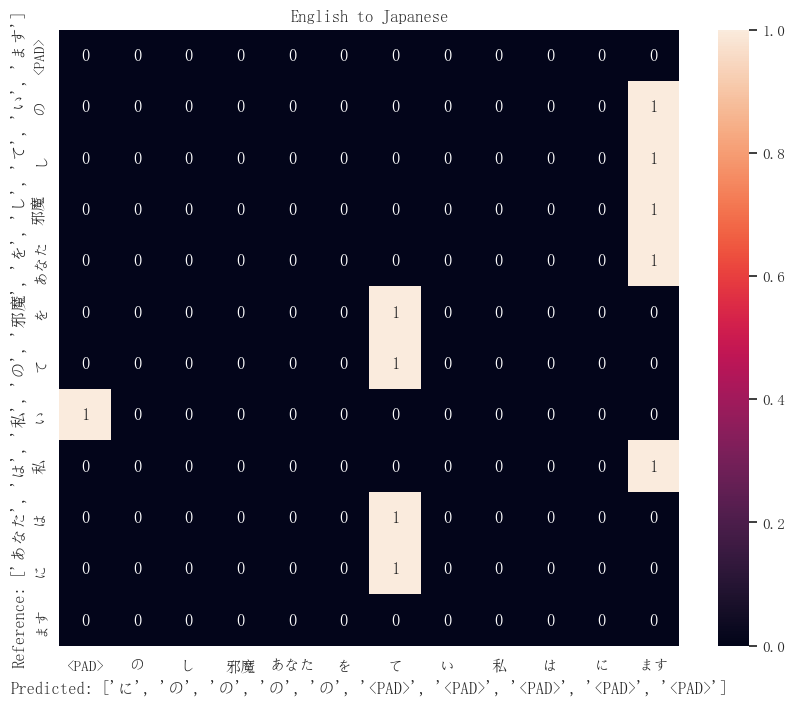

In [319]:
heatmap(reference_jp_basic, predictions_enjp_basic, japanese_vocab, "English", "Japanese")

##### French to Japanese

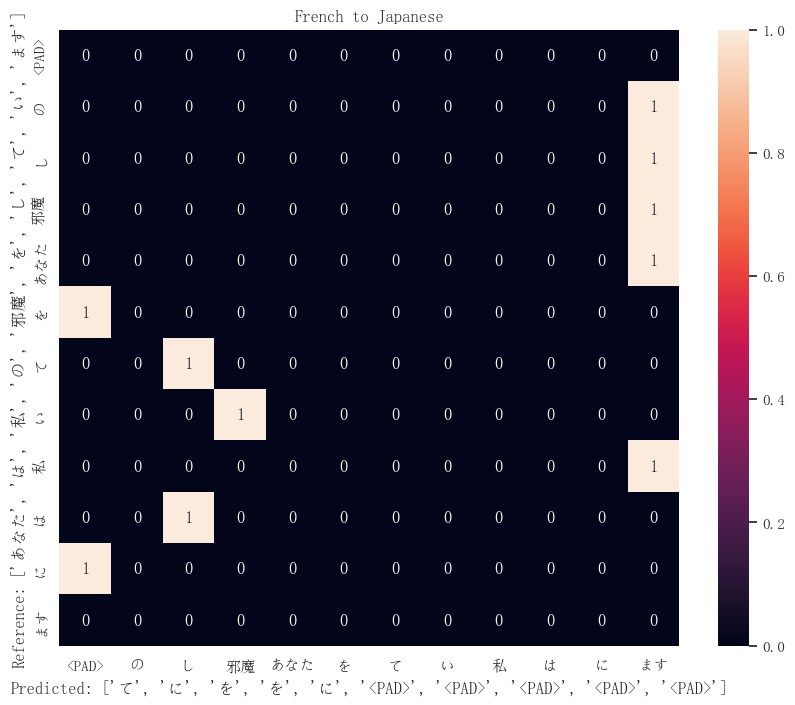

In [321]:
heatmap(reference_jp_basic, predictions_frjp_basic, japanese_vocab, "French", "Japanese")

### 3. Bar Plot of BLEU Scores Between English, French, and Japanese

In [323]:
bleu_score_data_basic = [fren_bleu_score_basic, jpen_bleu_score_basic, enfr_bleu_score_basic, jpfr_bleu_score_basic, enjp_bleu_score_basic, frjp_bleu_score_basic]

In [324]:
bleu_score_data_complex = [fren_bleu_score_complex, jpen_bleu_score_complex, enfr_bleu_score_complex, jpfr_bleu_score_complex, enjp_bleu_score_complex, frjp_bleu_score_complex]

In [325]:
bleu_score_data_book = [fren_bleu_score_book, jpen_bleu_score_book, enfr_bleu_score_book, jpfr_bleu_score_book, enjp_bleu_score_book, frjp_bleu_score_book]

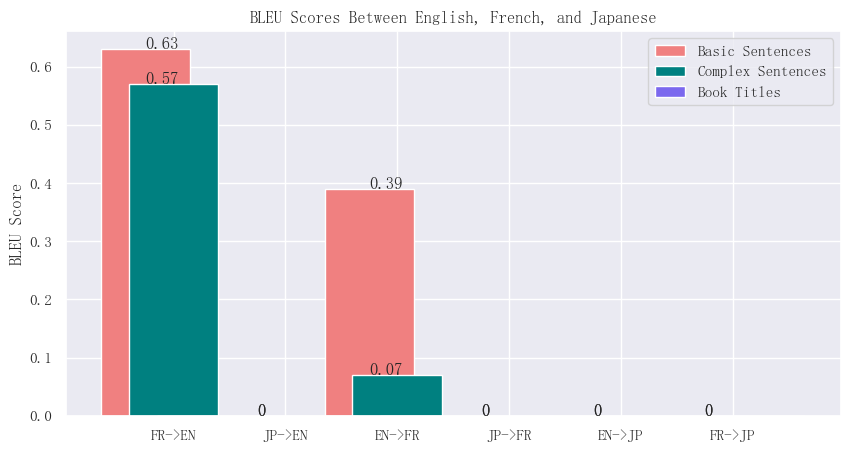

In [326]:
fig = plt.figure(figsize = (10, 5))
values = ["FR->EN", "JP->EN", "EN->FR", "JP->FR", "EN->JP", "FR->JP"]
bar_width = 0.25

bar_one = np.arange(len(bleu_score_data_basic))
bar_two = [x + bar_width for x in bar_one]
bar_three = [x + bar_width for x in bar_two]

plt.bar(bar_one, bleu_score_data_basic, label = "Basic Sentences", color = "lightcoral")
plt.bar(bar_two, bleu_score_data_complex, label = "Complex Sentences", color = "teal")
plt.bar(bar_three, bleu_score_data_book, label = "Book Titles", color = "mediumslateblue")

for i in range(len(bar_one)):
    plt.text(i, bleu_score_data_basic[i], bleu_score_data_basic[i])

for i in range(len(bar_two)):
    plt.text(i, bleu_score_data_complex[i], bleu_score_data_complex[i])


plt.xticks([j + bar_width for j in range(len(bleu_score_data_basic))], values)
plt.ylabel("BLEU Score")
plt.title("BLEU Scores Between English, French, and Japanese")
plt.legend()

plt.show()